# Dependencies 

## Imports 

In [2]:
# imports 
# base python
import os
import copy
import re
from sys import getsizeof
import random

# scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
%matplotlib inline
import seaborn as sns
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import preprocessing
import matplotlib.tri as tri
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

plt.rcParams["figure.figsize"] = (20,7)

#ase
from ase.io import gen, vasp, xyz, extxyz, dftb
from ase.io.dftb import read_dftb_velocities, write_dftb_velocities
from ase.calculators.dftb import Dftb
from ase import Atoms, Atom
from ase.constraints import FixAtoms
from ase.visualize import view
from ase.build import make_supercell
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
import nglview
from ase.geometry.analysis import Analysis

#dscribe
from dscribe.descriptors import SOAP
from dscribe.descriptors import MBTR
from dscribe.kernels import REMatchKernel
from dscribe.kernels import AverageKernel

from sklearn import preprocessing


#quippy 
from ase.build import bulk
from ase.optimize import LBFGS
from ase.visualize import view
from quippy.potential import Potential


#misc
import similaritymeasures


_ColormakerRegistry()

## Functions

In [3]:
def show_atoms_grid(data, rotation = '-0x,0y,0z', save= False, filename = 'grid_configs'):
    '''
    Where data is list of Atoms objects
    '''
    dim = int(np.ceil(np.sqrt(len(data))))
    fig, axarr = plt.subplots(dim, dim, figsize=(25, 25))
    for i, config in enumerate(data):
        plot_atoms(config, axarr[i%dim,i//dim], rotation = rotation)
    if save:
        fig.savefig(filename + ".png")
        
def normalize(y,x):
    """
    Takes y, x of data and returns normalized y
    """
    return y/np.trapz(y,x)

def KE(v_tot):
    "Returns KE of Ar+ in eV given total velocity"
    return 6.24E18 * 0.5 * 1.66E-27*39.95*(v_tot*1E5)**2

def v_from_KE(E):
    "Returns v(z) of Ar+ in eV given KE"
    return np.sqrt(E/(6.24E18 * 0.5 * 1.66E-27*39.95))/1E5

## Structures

In [4]:
mef = vasp.read_vasp("reference_files/CONTCAR_mef")
cf4 = vasp.read_vasp("reference_files/CONTCAR_cf4")
amorphous = vasp.read_vasp("reference_files/CONTCAR_amorphous_cubic")
xtl_n = vasp.read_vasp("reference_files/CONTCAR_nrich")
xtl_si = vasp.read_vasp("reference_files/CONTCAR_sirich")
xtl2x2 = gen.read_gen("reference_files/2x2xtl.gen")
xtl2x2_sifterm = gen.read_gen("reference_files/2x2xtl_sifterm.gen")
heavy_bomb = vasp.read_vasp("reference_files/CONTCAR_heavy_bombard")
bulk222 = vasp.read_vasp("reference_files/CONTCAR_222bulk")
annealed = vasp.read_vasp("reference_files/CONTCAR_annealed_unitcell")

# Read structures

## 0K crystal structure

Sort xtl2x2 to make things more easy to deal with.

In [4]:
outstruct = xtl2x2.copy()
order = [atom.index for atom in sorted(outstruct, key = lambda atom: atom.position[2])]

tempstruct = Atoms(sorted(outstruct, key = lambda atom: atom.position[2]))
del outstruct[[atom.index for atom in outstruct]]
outstruct += tempstruct
# outstruct.constraints = FixAtoms(np.arange(160))
view(outstruct)
xtl2x2 = outstruct

Seed grid points for adsorbate

In [5]:
gridpts = np.linspace(0, 1, 9)
x, y = np.meshgrid(gridpts, gridpts)
z = np.zeros(x.shape)
coords = list(zip(x.flatten(),y.flatten(),z.flatten()))
coords = list(map(xtl2x2.cell.cartesian_positions, coords))
adsorbedStructs0KXtl = []
for xi, yi, zi in coords:
    adsorbedStruct = xtl2x2.copy() 
    add_adsorbate(adsorbedStruct, 'He', position = (xi, yi), height = 1)
    adsorbedStructs0KXtl += [adsorbedStruct]
    
# view(adsorbedStructs)

## Thermalized xtl structure

In [6]:
np.random.seed(429)
thermalStructsXtl = []
for choice in np.random.choice(np.arange(100, 1100), size = 170, replace = False):
    choice = int(choice) # because this package doesn't support numpy ints...........
    tempstruct = [i for i in xyz.read_xyz("../training/crystal/100K.xyz", index = choice)][0]
    tempstruct.cell = xtl2x2.cell
    thermalStructsXtl.append(tempstruct)
# view(thermalStructsXtl)

## Read sim data, trim ejected species.

In [7]:
datadir = "../training/bomb0.13/" #bare bombardment, v0.13 = 35.0 eV, 0.135 = 37.7 eV, .14 = 40.55 eV
geometries = {}
for i in os.listdir(datadir):
    if ".gen" in i:
        key = re.search(r"\d+-\d+", i)
        if key:
            key = key.group(0)
            geometries[key] =  gen.read_gen(datadir + i)

zcutoff = max([i.position[2] for i in xtl2x2]) + 1 # remove everything but immediate surface

trimmedgeoms = dict()

removedspecies = dict()

for key, geom in geometries.items(): 
    aboveZindices = set()
    belowZindices = set()
    otherindices = set()
    nearbyatoms = set()
    removedatoms = {'Si': 0, 'N': 0, 'H': 0, 'Ar': 0, 'F':0 }
    for atom in geom:
        if atom.position[2] > zcutoff:
            aboveZindices.add(atom.index)
        elif atom.position[2] < .1:
            belowZindices.add(atom.index)
        else:
            otherindices.add(atom.index)
    # iteration through geom once guarantees uniqueness in aboveZindices and otherindices 
    
    for i in aboveZindices:
        _dists = geom.get_distances(i, list(otherindices))
        nearbyatoms.update(np.array(list(otherindices))[_dists < 2]) 
        # add indices where distance to i is less than 2
    atomstoremove = aboveZindices.union(nearbyatoms).union(belowZindices)
    
    for idx in atomstoremove:
        removedatoms[geom[idx].symbol] += 1
    
    geomcopy = geom.copy()
#     geomcopy.wrap()
    del geomcopy[[atom.index for atom in geomcopy if atom.index in atomstoremove]]
    
    removedspecies[key] = pd.Series(removedatoms)
    trimmedgeoms[key] = geomcopy
    
# collect all removed species series into a df
removedspecies = pd.DataFrame(removedspecies)
geometries = trimmedgeoms

view([geometries[key] for key in geometries.keys()])

# Apply SOAP to xtl

Create SOAP descriptor, and also reference environment measures for Si and N in bulk SiN

In [8]:
desc = SOAP(species=[1, 2, 7, 14, 18], 
             rcut=5.0, 
             nmax=10, 
             lmax=9, 
             sigma=0.1, 
             periodic=True, 
             crossover=True, 
             sparse=False)

# create reference atomwise SOAP descriptor of xtl bulk 2x2 structure
bulkfeatures = preprocessing.normalize(desc.create(bulk222))
# create reference arrays for xtl Si atom and xtl N atom
siref = bulkfeatures[0].reshape(1, -1)
nref = bulkfeatures[-1].reshape(1, -1)

Apply SOAP to 0K crystal surface

In [9]:
pointSOAPs0K = []
for adsorbedStruct in adsorbedStructs0KXtl:
    pointSOAP = preprocessing.normalize(desc.create(adsorbedStruct, positions=[296])) # SOAP representation of temp 
    pointSOAPs0K += [pointSOAP[0]]
pointSOAPs0K = np.array(pointSOAPs0K)

Visualize He index number, 0 indexed on He0

In [10]:
vizStruct = xtl2x2.copy()
charges = [0] * len(vizStruct)
for xi, yi, zi in coords:
    add_adsorbate(vizStruct, 'He', position = (xi, yi), height = 1)

charges += list(np.arange(len(coords)))
vizStruct.set_initial_charges(charges)
# view(vizStruct)

## Various ways of visualizing the SOAP results

Visualize `pointSOAPs` by direct plot, dimensionality reduction

In [11]:
pointSOAPs0K.shape

(81, 8250)

In [12]:
np.random.seed(429)
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
transf_mds = MDS(n_components=2)
transf_tsne = TSNE(n_components=2) 
mdsSOAPs0K = transf_mds.fit_transform(pointSOAPs0K)
tsneSOAPs0K = transf_tsne.fit_transform(pointSOAPs0K) 

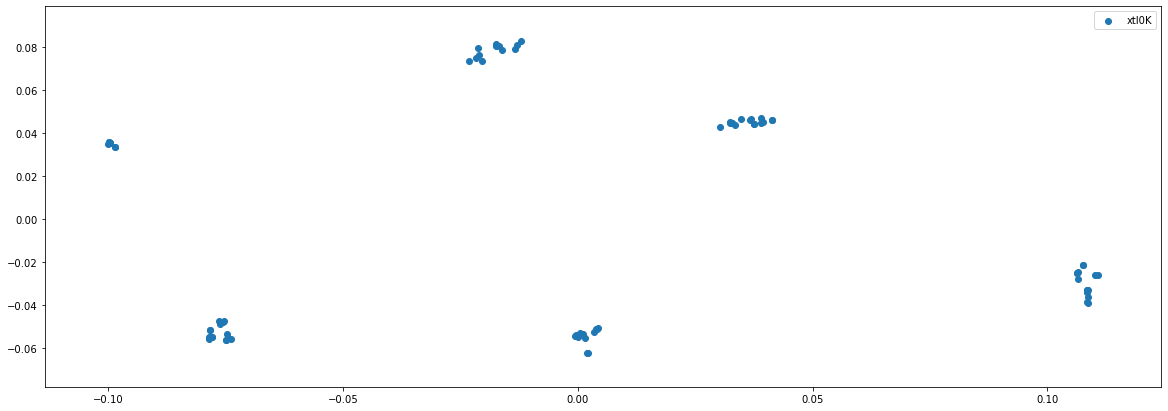

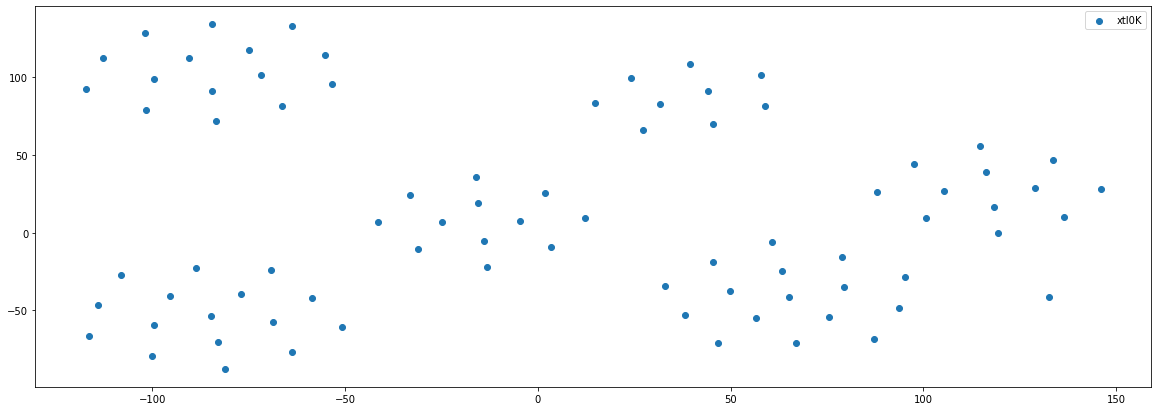

In [13]:
plt.scatter(mdsSOAPs0K[:, 0], mdsSOAPs0K[:, 1], label = 'xtl0K');
plt.legend();
plt.show()
plt.scatter(tsneSOAPs0K[:, 0], tsneSOAPs0K[:, 1], label = 'xtl0K');
plt.legend();

use k means to determine what exactly these clusters are

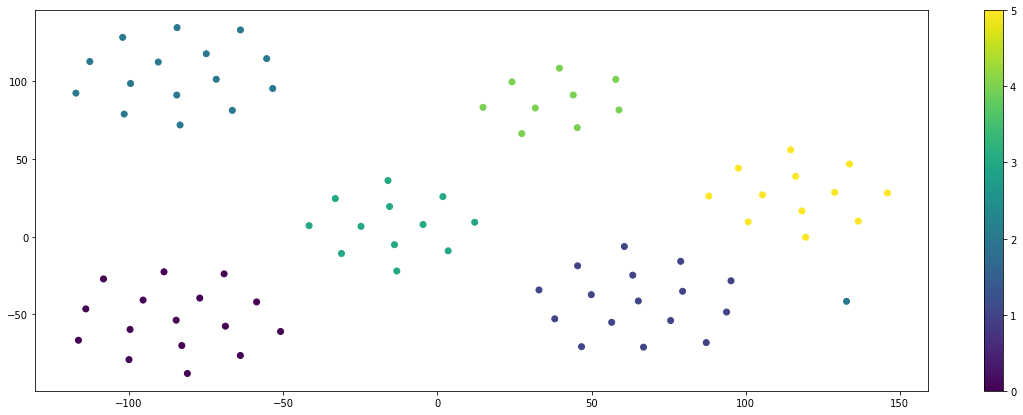

In [14]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=6, random_state=0).fit(pointSOAPs0K)


plt.scatter(tsneSOAPs0K[:,0], tsneSOAPs0K[:,1], 
            c=kmeans.labels_, cmap='viridis')

cb = plt.colorbar()
plt.show()


Visualize in structure

In [15]:
vizStruct = xtl2x2.copy()
charges = [0] * len(vizStruct)
for xi, yi, zi in coords:
    add_adsorbate(vizStruct, 'He', position = (xi, yi), height = 1)

charges += list(kmeans.labels_ + 1)
vizStruct.set_initial_charges(charges)
view(vizStruct)

# Apply SOAP to sim structures 

Create `geomSOAPgrids` dict, which contains `runID:SOAP`, where `SOAP` will be a `#He_pts x #features` matrix

In [16]:
geomSOAPgrids = {}
for i, geom in geometries.items(): # iterate over all bombarded structs
    temp = geom.copy()
    tempSOAPs = []
    # get SOAP representation for each atom as generated according to `coords` array
    for xi, yi, zi in coords: # iterate over coordinates grid specified at head of notebook
        pointStruct = temp.copy() 
        add_adsorbate(pointStruct, 'He', position = (xi, yi), height = 1)
        arPosition = len(pointStruct) - 1
        tempSOAP = preprocessing.normalize(
            desc.create(pointStruct, positions = [arPosition])) # SOAP representation of temp 
        tempSOAPs += [tempSOAP[0]]
    tempSOAPs = np.array(tempSOAPs)
    geomSOAPgrids[i] = tempSOAPs
    
    

Get coordinates of Ar starting point (and therefore bombardment point) for each run:

In [17]:
np.random.seed(429) 

num_dirs = 10
runs_per_dir = 17 #4 cores per run, 68 cores on st2 
output_dir = "../inputs/"

arpositions = {}

# refz = ref.positions[-1,2]
for d in range(num_dirs):
    for run in range(runs_per_dir):
        arpositions["%d-%d" % (d, run)] = xtl2x2.cell.cartesian_positions(
            np.append(np.random.random(2), 0)) #z coord needs dummy var

Visualize:

In [18]:
transf_mds = MDS(n_components=2)
transf_tsne = TSNE(n_components=2) 
numCompare = 6
i = 0

mdsSOAPsbombed = {}
tsneSOAPsbombed = {}
for label, soap in geomSOAPgrids.items(): 
    if i == numCompare:
        break
    i += 1
    mdsSOAPstemp = transf_mds.fit_transform(soap.astype(np.float64))
    tsneSOAPstemp = transf_tsne.fit_transform(soap.astype(np.float64)) 
    mdsSOAPsbombed[label] = mdsSOAPstemp
    tsneSOAPsbombed[label] = tsneSOAPstemp
    

Identify surface points within the 'zone of influence' for each run:

In [19]:
vizStructs = []
isNear = {}
cutoff = 5

for key in arpositions.keys():
    thisPosition = arpositions[key]
    vizStruct = xtl2x2.copy()
    charges = np.zeros(len(vizStruct))
    for xi, yi, zi in coords:
        add_adsorbate(vizStruct, 'He', position = (xi, yi), height = 1)
    add_adsorbate(vizStruct,'Ar', height = 1, position = thisPosition[:-1])
    isNear[key] = (vizStruct.get_all_distances(mic = True)[-1])[len(charges - 1):-1] < cutoff
    charges = np.append(charges, isNear[key])
    charges = np.append(charges, 2)
    vizStruct.set_initial_charges(charges)
    vizStructs += [vizStruct]

view(vizStructs)

Visualize if `isNear` and `xxxSOAPsbombed` show any structure for a few example structures?

In [20]:
mdsSOAPsbombed.keys()

dict_keys(['2-13', '5-7', '6-6', '7-8', '0-4', '8-14'])

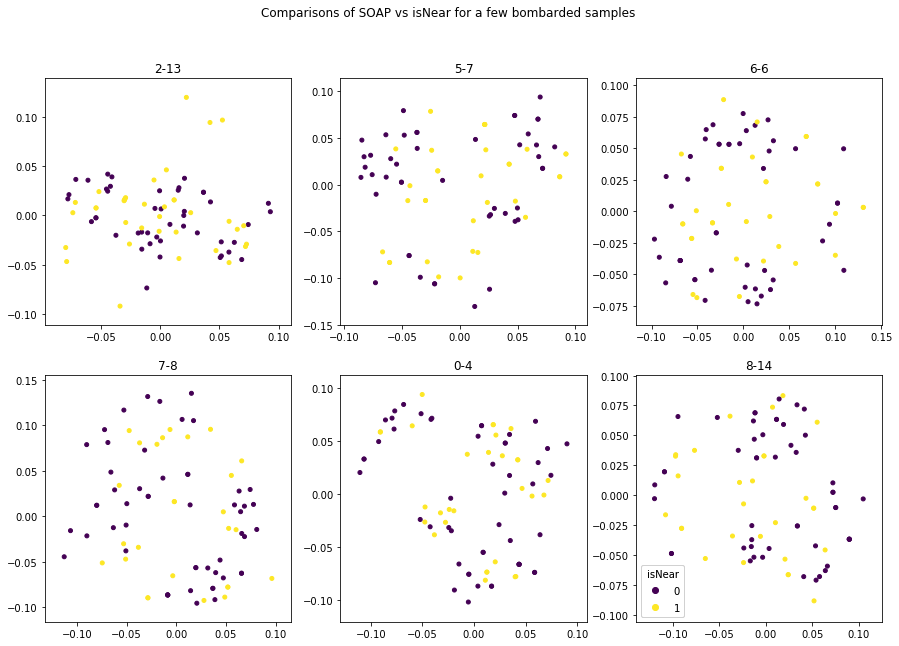

In [21]:
fig, axs = plt.subplots(2,3, figsize=(15, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i, key in enumerate(mdsSOAPsbombed.keys()):
    thisone = mdsSOAPsbombed[key]
    im = axs[i].scatter(thisone[:, 0], thisone[:, 1], s = 16, c = isNear[key], label = isNear[key])
    axs[i].set_title(key)
    
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)
# fig.legend()

# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*im.legend_elements(),
                    loc="lower left", title="isNear")
axs[5].add_artist(legend1)
fig.suptitle("Comparisons of SOAP vs isNear for a few bombarded samples ");

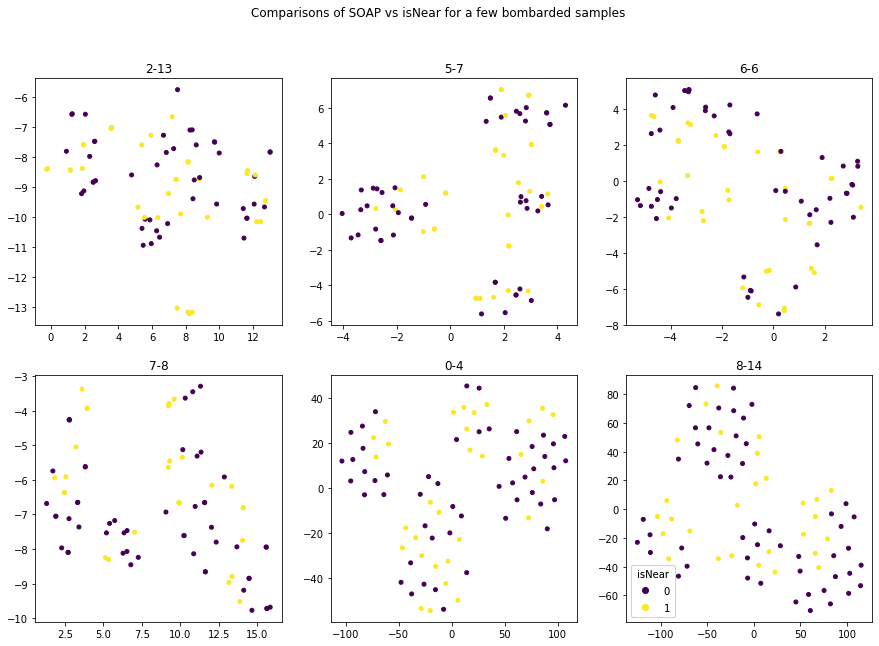

In [22]:
fig, axs = plt.subplots(2,3, figsize=(15, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i, key in enumerate(tsneSOAPsbombed.keys()):
    thisone = tsneSOAPsbombed[key]
    im = axs[i].scatter(thisone[:, 0], thisone[:, 1], s = 16, c = isNear[key], label = isNear[key])
    axs[i].set_title(key)
    
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)
# fig.legend()

# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*im.legend_elements(),
                    loc="lower left", title="isNear")
axs[5].add_artist(legend1)
fig.suptitle("Comparisons of SOAP vs isNear for a few bombarded samples ");

### KMeans this stuff???

In [23]:
## prepare training set by including all bombarded structures
allBombSoaps = np.vstack([value for value in geomSOAPgrids.values()])

Fit classifier

In [54]:
kmeans = KMeans(n_clusters=4, random_state=0, tol=0.0000001).fit(allSoaps)

Visualize on example

In [55]:
mdsSOAPsbombed.keys()

dict_keys(['2-13', '5-7', '6-6', '7-8', '0-4', '8-14'])

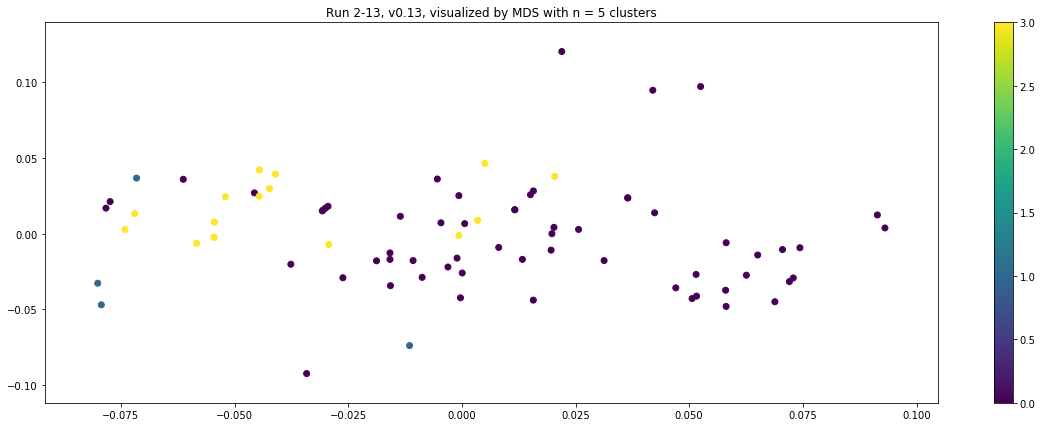

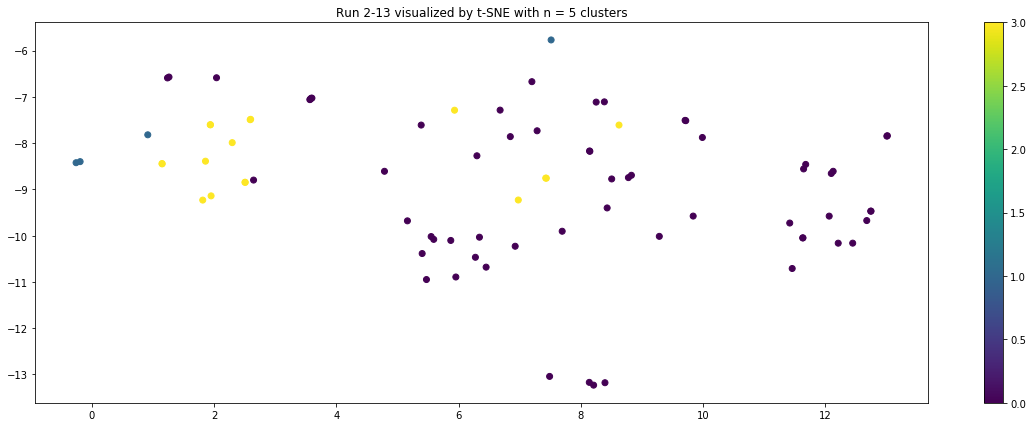

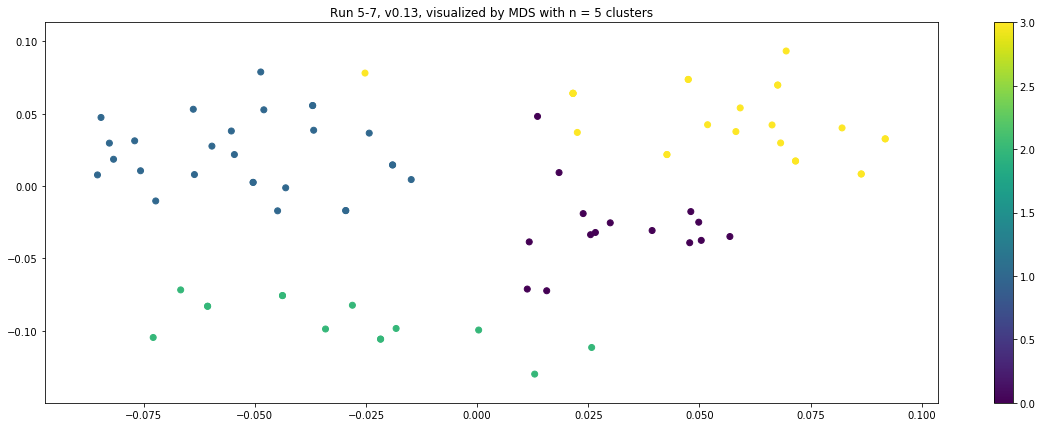

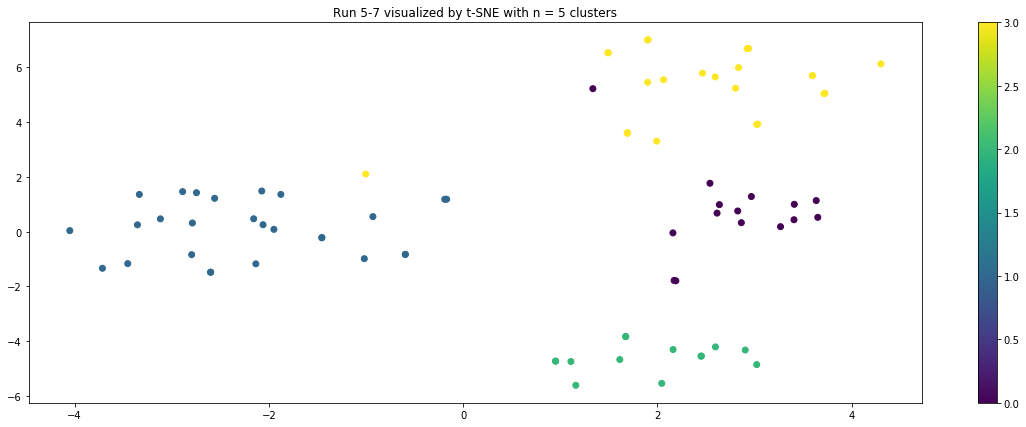

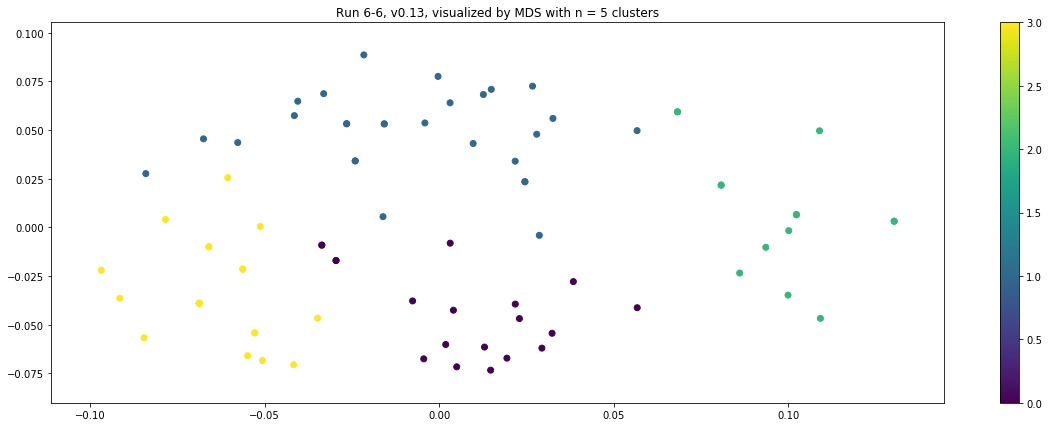

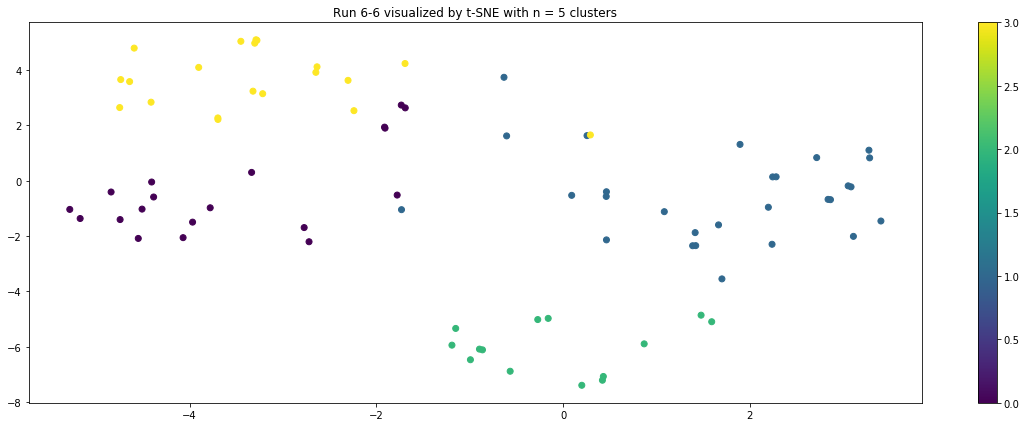

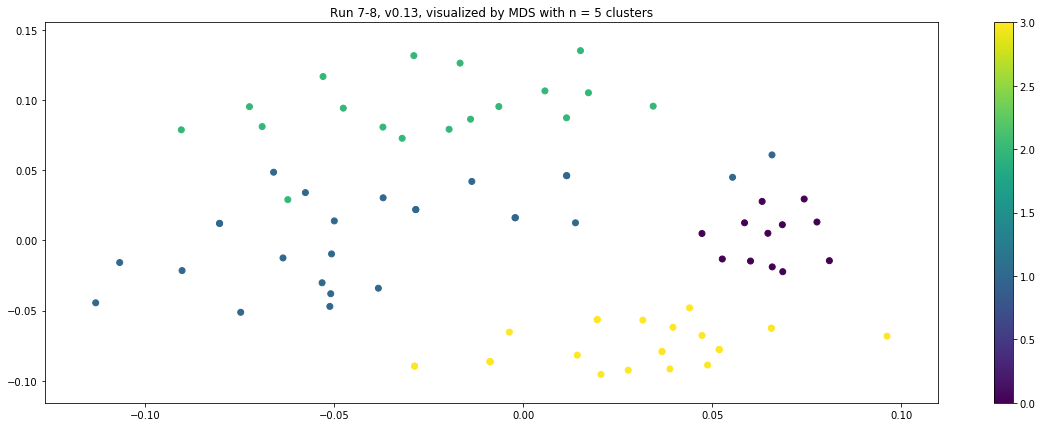

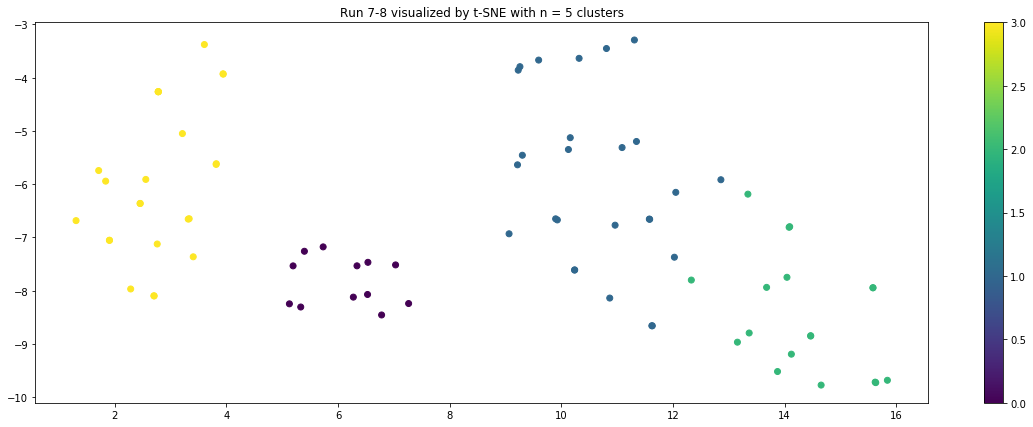

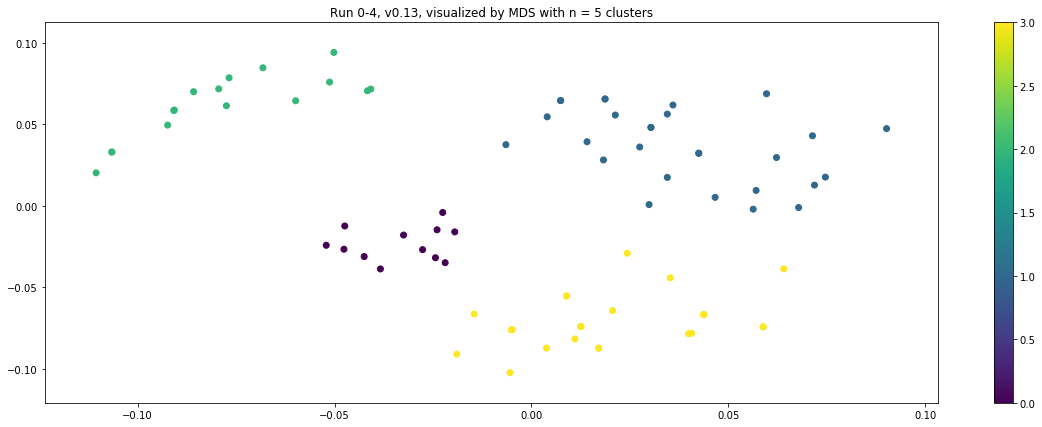

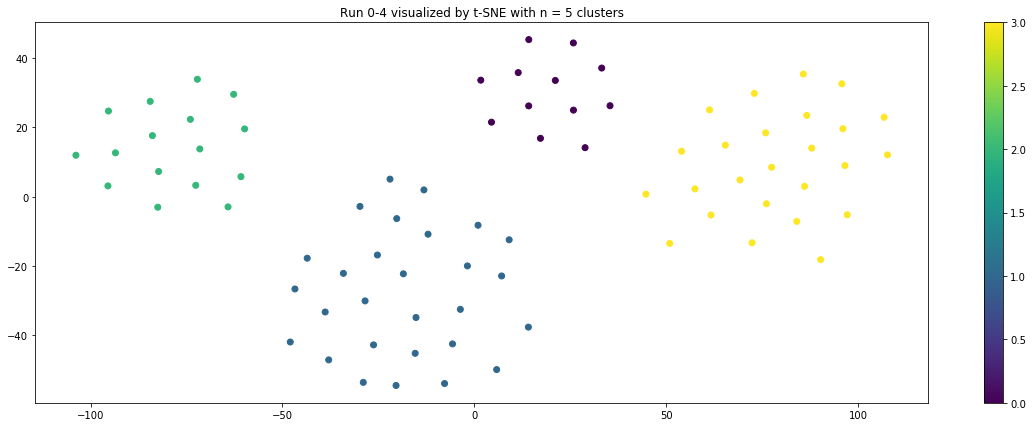

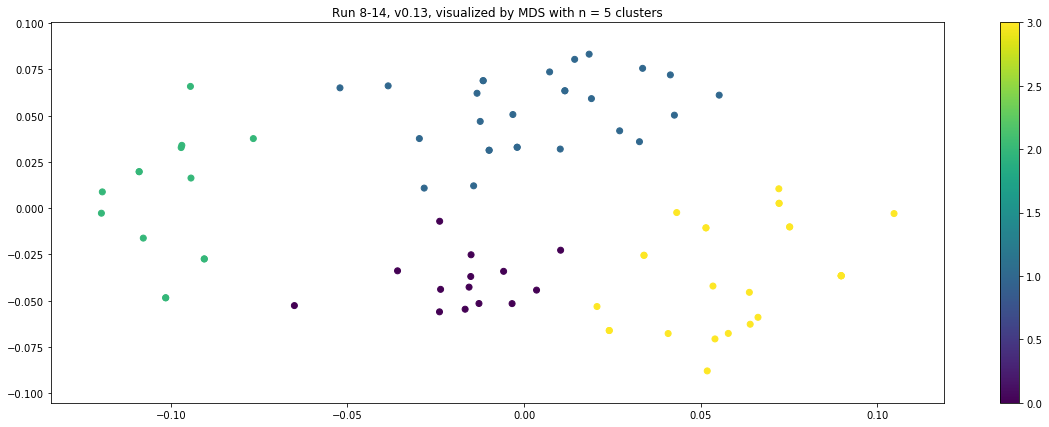

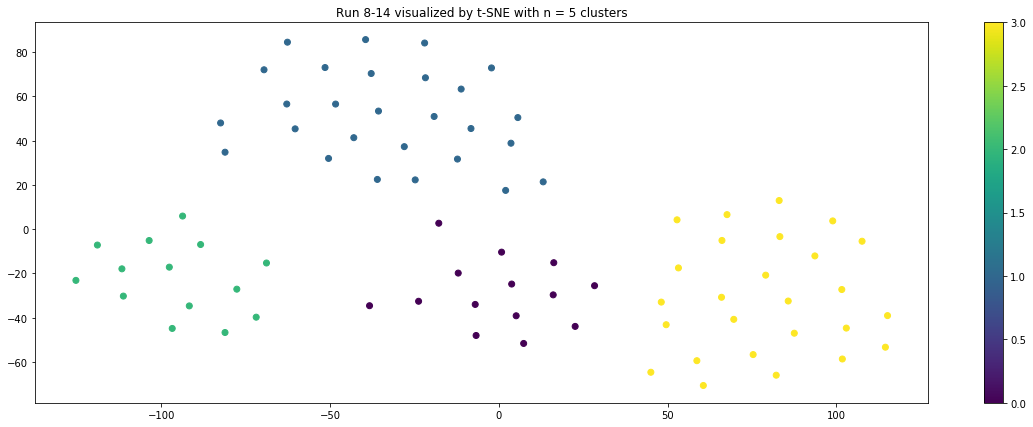

In [56]:
for testKey in mdsSOAPsbombed.keys():
    testStruct = geomSOAPgrids[testKey]
    testMDS = mdsSOAPsbombed[testKey]
    testTsne = tsneSOAPsbombed[testKey]
    plt.title("Run %s, v0.13, visualized by MDS with n = 5 clusters" % testKey)
    plt.scatter(testMDS[:,0], testMDS[:,1], 
                c=kmeans.predict(testStruct), cmap='viridis')

    cb = plt.colorbar()
    plt.show()
    plt.title("Run %s visualized by t-SNE with n = 5 clusters" % testKey)
    plt.scatter(testTsne[:,0], testTsne[:,1], 
                c=kmeans.predict(testStruct), cmap='viridis')

    cb = plt.colorbar()
    plt.show()

Visualize in structure

In [27]:
view(vizStruct)

In [57]:
vizStructs = []
isNear = {}
cutoff = 5


for key in mdsSOAPsbombed.keys():
    thisPosition = arpositions[key]
    testStruct = geomSOAPgrids[key]
    vizStruct = geometries[key].copy()
    vizStruct.wrap()
    charges = np.zeros(len(vizStruct))
    for xi, yi, zi in coords:
        add_adsorbate(vizStruct, 'He', position = (xi, yi), height = 1)
    add_adsorbate(vizStruct,'Ne', height = 1, position = thisPosition[:-1])
    charges = np.append(charges, kmeans.predict(testStruct) + 1)
    charges = np.append(charges, -1)
    vizStruct.set_initial_charges(charges)
    vizStructs += [vizStruct]

view(vizStructs)

Just kmeans 2-13

In [29]:
vizStructs = []

smallkmeans = KMeans(n_clusters=4, random_state=0, tol=1e-20).fit(geomSOAPgrids['2-13']) 

for key in ['2-13']:
    thisPosition = arpositions[key]
    testStruct = geomSOAPgrids[key]
    vizStruct = geometries[key].copy()
    vizStruct.wrap()
    charges = np.zeros(len(vizStruct))
    for xi, yi, zi in coords:
        add_adsorbate(vizStruct, 'He', position = (xi, yi), height = 1)
    add_adsorbate(vizStruct,'Ne', height = 1, position = thisPosition[:-1])
    charges = np.append(charges, kmeans.predict(testStruct) + 1)
    charges = np.append(charges, -1)
    vizStruct.set_initial_charges(charges)
    vizStructs += [vizStruct]

view(vizStructs)

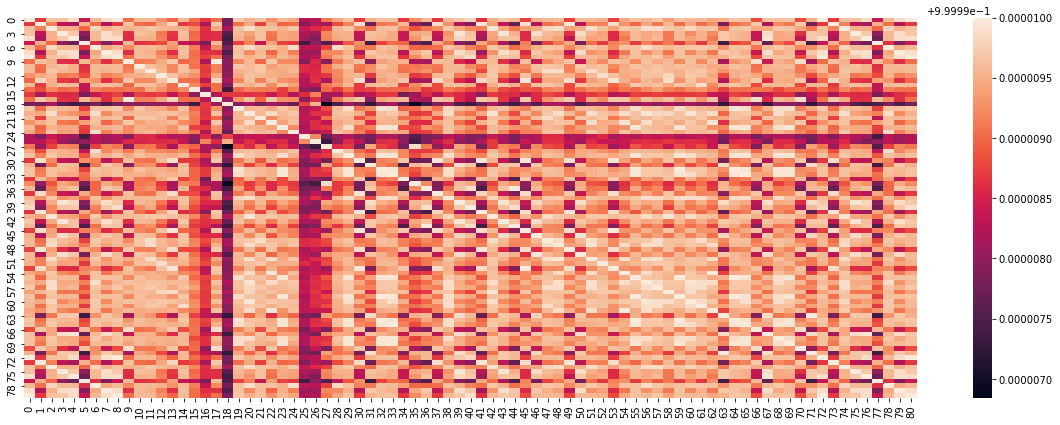

In [30]:
ax = sns.heatmap(rbf_kernel(geomSOAPgrids['2-13']))

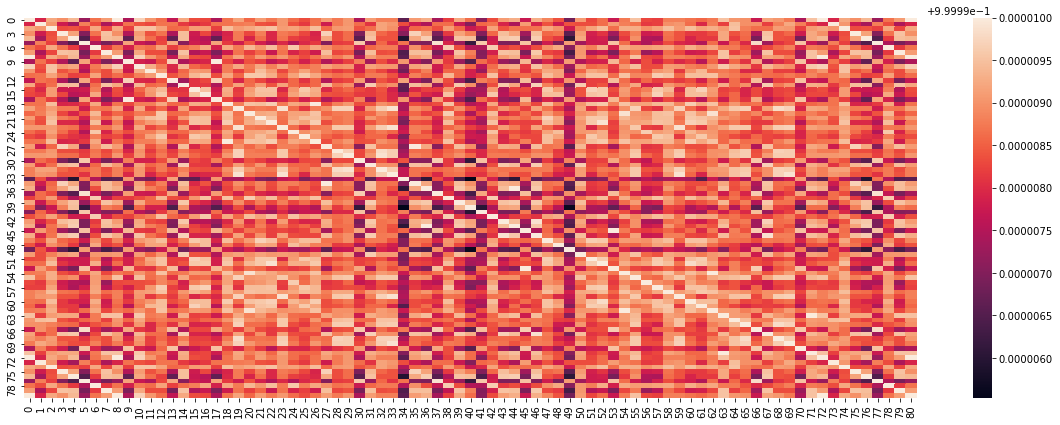

In [31]:
ax = sns.heatmap(rbf_kernel(geomSOAPgrids['5-7']))

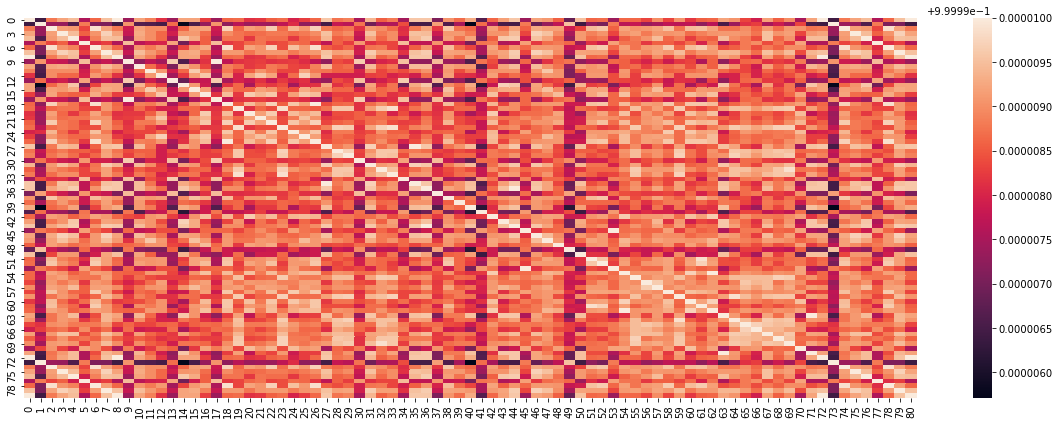

In [32]:
ax = sns.heatmap(rbf_kernel(geomSOAPgrids['6-6']))

### Hierarchical

In [33]:
# from sklearn.cluster import AgglomerativeClustering
# hier = AgglomerativeClustering(n_clusters=5)
# model = hier.fit(allBombSoaps)

In [34]:
# from scipy.cluster.hierarchy import dendrogram
# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack([model.children_, model.distances_,
#                                       counts]).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)
    
# plt.title('Hierarchical Clustering Dendrogram')
# # plot the top three levels of the dendrogram
# plot_dendrogram(hier, truncate_mode='level', p=4)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [35]:
# pd.unique(model.labels_)

In [36]:
# import numpy as np
# from sklearn.cluster import AgglomerativeClustering
# import itertools

# X = np.concatenate([np.random.randn(3, 10), np.random.randn(2, 10) + 100])
# model = AgglomerativeClustering(linkage="average", affinity="cosine")
# model.fit(X)

# ii = itertools.count(X.shape[0])
# [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

In [37]:
# [value for value in geomSOAPgrids.values()] == [geomSOAPgrids[key] for key in geomSOAPgrids.keys()]

In [38]:
# hier.labels_.shape

In [40]:
# print(
#     np.all(np.vstack([geomSOAPgrids[key] for key in geomSOAPgrids.keys()]) == allBombSoaps)
# )
# hierlabels = {}
# glommedhierlabels = hier.labels_.copy()
# i = 0
# for i, key in enumerate(geomSOAPgrids.keys()):
#     hierlabels[key] = []
#     for j in range(81):
# #         print(glommedhierlabels[i*81 + j])
#         hierlabels[key] += [glommedhierlabels[i*81 + j]]
        
        

In [41]:
# vizStructs = []
# isNear = {}
# cutoff = 5


# for key in mdsSOAPsbombed.keys():
#     thisPosition = arpositions[key]
#     testStruct = geomSOAPgrids[key]
#     vizStruct = geometries[key].copy()
#     vizStruct.wrap()
#     charges = np.zeros(len(vizStruct))
#     for xi, yi, zi in coords:
#         add_adsorbate(vizStruct, 'He', position = (xi, yi), height = 1)
#     add_adsorbate(vizStruct,'Ne', height = 1, position = thisPosition[:-1])
#     charges = np.append(charges, np.array(hierlabels[key]) + 1)
#     charges = np.append(charges, -1)
#     vizStruct.set_initial_charges(charges)
#     vizStructs += [vizStruct]

# view(vizStructs)

In [42]:
# from ase.geometry import distance
# distance(xtl2x2, geometries['2-13'])

### SVM

In [43]:
# from sklearn.svm import SVC
# SVC(comput)


# Apply SOAP to thermal xtl structures

In [44]:
thermalSOAPgrids = []
for geom in thermalStructsXtl:
    temp = geom.copy()
    # get SOAP representation for each atom as generated according to `coords` array
    tempSOAPs = []
    for xi, yi, zi in coords:
        pointStruct = temp.copy() 
        add_adsorbate(pointStruct, 'He', position = (xi, yi), height = 1)
        arPosition = len(pointStruct) - 1
        tempSOAP = preprocessing.normalize(
            desc.create(pointStruct, positions = [arPosition])) # SOAP representation of temp 
        tempSOAPs += [tempSOAP[0]]
    tempSOAPs = np.array(tempSOAPs)
    thermalSOAPgrids += [tempSOAPs]

In [45]:
## prepare training set by including all bombarded structures
allThermalSoaps = np.vstack(np.array(thermalSOAPgrids))

In [46]:
allSoaps = np.vstack((allThermalSoaps, allBombSoaps))
allSoaps.shape

(27540, 8250)

In [47]:
kmeans = KMeans(n_clusters=4, random_state=0, tol=0.0001).fit(allSoaps)

In [48]:
transf_mds = MDS(n_components=2)
transf_tsne = TSNE(n_components=2) 
numCompare = 5
i = 0

mdsSOAPsthermal = {}
tsneSOAPsthermal = {}
for label, soap in enumerate(thermalSOAPgrids): 
    if i == numCompare:
        break
    i += 1
    mdsSOAPstemp = transf_mds.fit_transform(soap.astype(np.float64))
    tsneSOAPstemp = transf_tsne.fit_transform(soap.astype(np.float64)) 
    mdsSOAPsthermal[label] = mdsSOAPstemp
    tsneSOAPsthermal[label] = tsneSOAPstemp

In [49]:
# plt.figure(figsize = (10, 10))
# for label, rep in mdsSOAPsthermal.items():
#     plt.scatter(rep[:, 0], rep[:, 1], label = label);

# plt.scatter(mdsSOAPs0K[:, 0], mdsSOAPs0K[:, 1], label = '0K');
# plt.legend();
# mpld3.display()

In [58]:
vizStructs = []
isNear = {}
cutoff = 5


for i in range(cutoff):
    testStruct = thermalSOAPgrids[i].copy()
    vizStruct = thermalStructsXtl[i].copy()
    vizStruct.wrap()
    charges = np.zeros(len(vizStruct))
    for xi, yi, zi in coords:
        add_adsorbate(vizStruct, 'He', position = (xi, yi), height = 1)
    charges = np.append(charges, kmeans.predict(testStruct) + 1)
    vizStruct.set_initial_charges(charges)
    vizStructs += [vizStruct]

view(vizStructs)

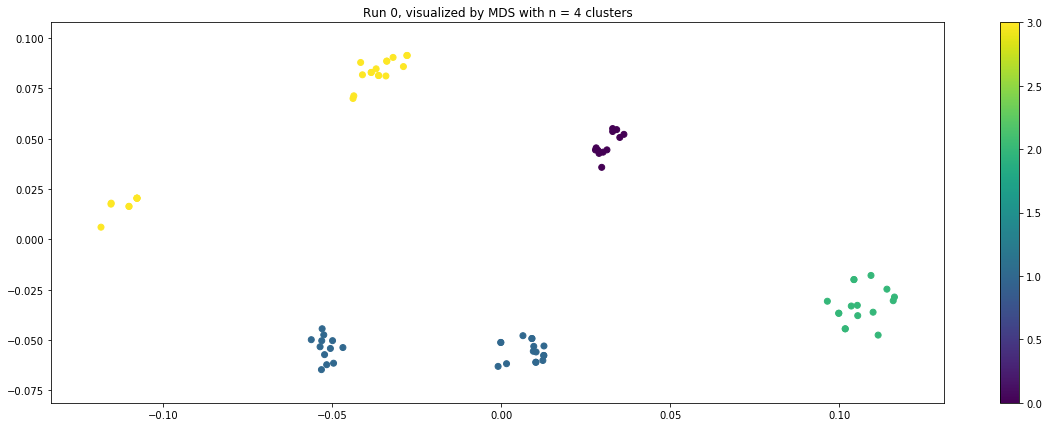

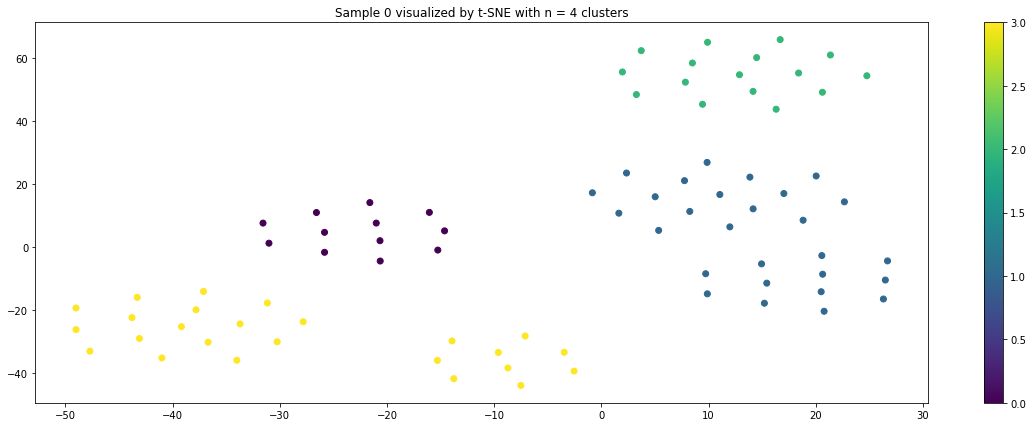

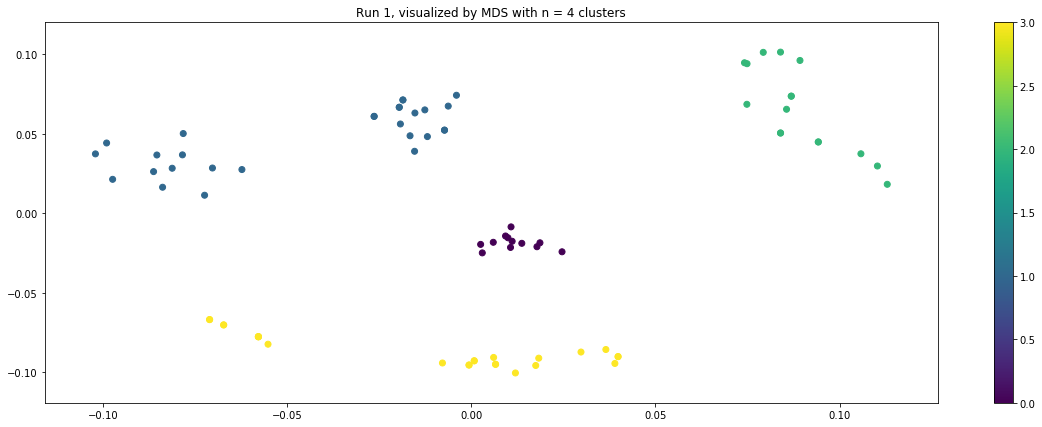

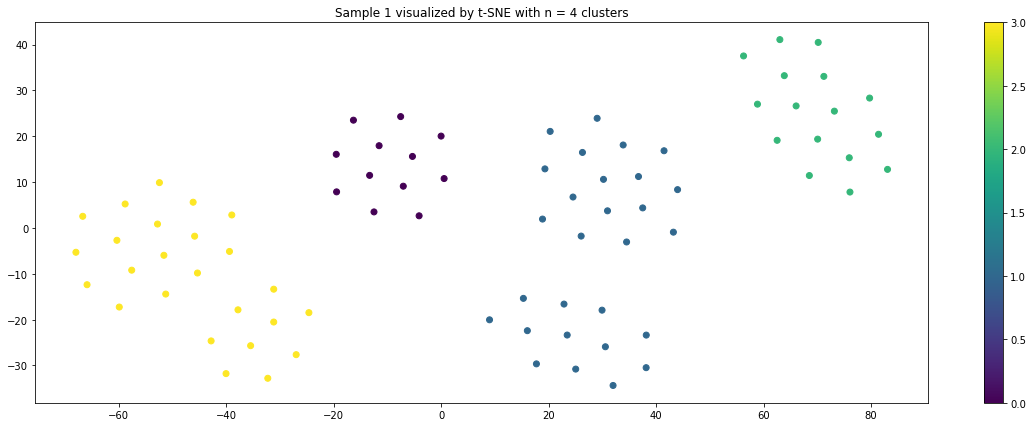

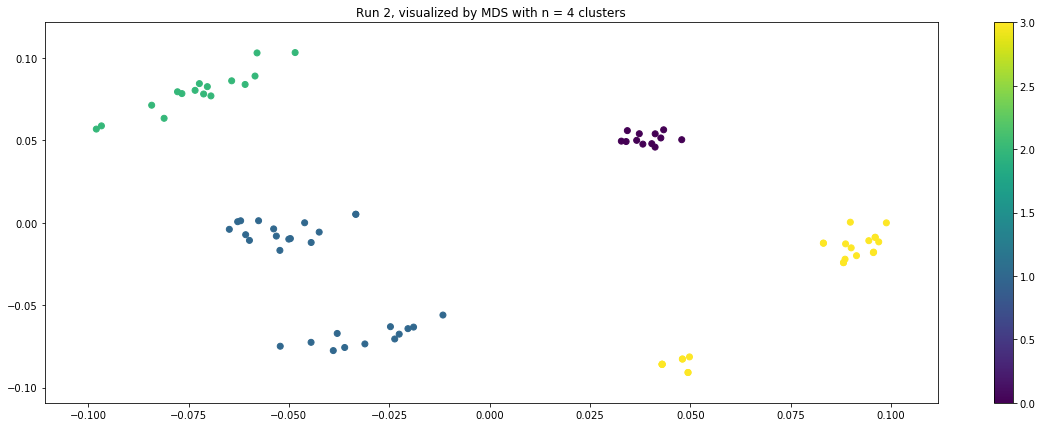

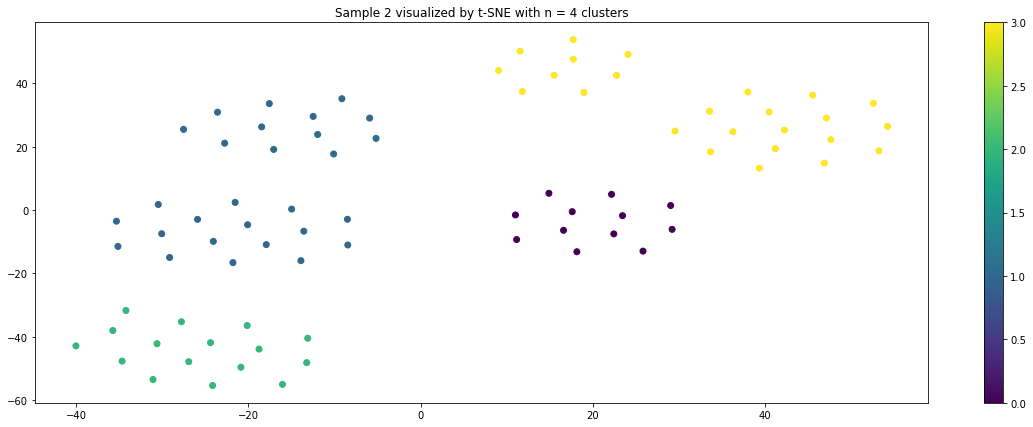

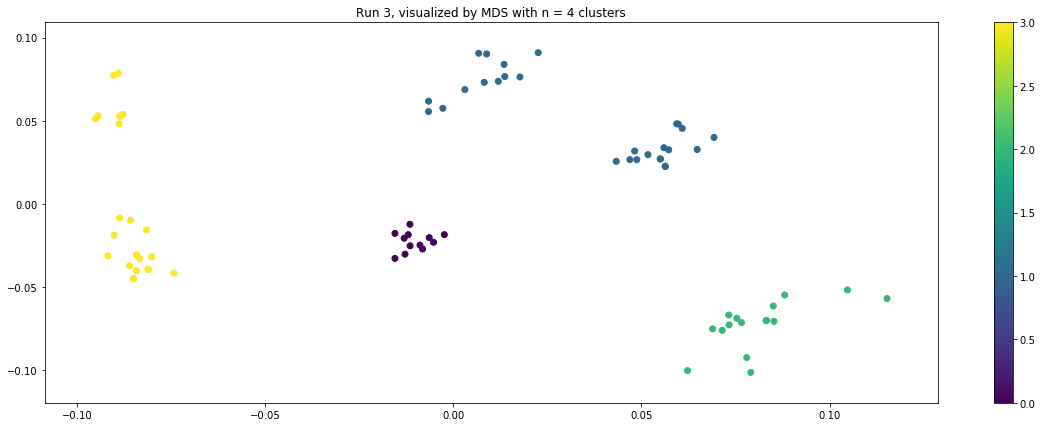

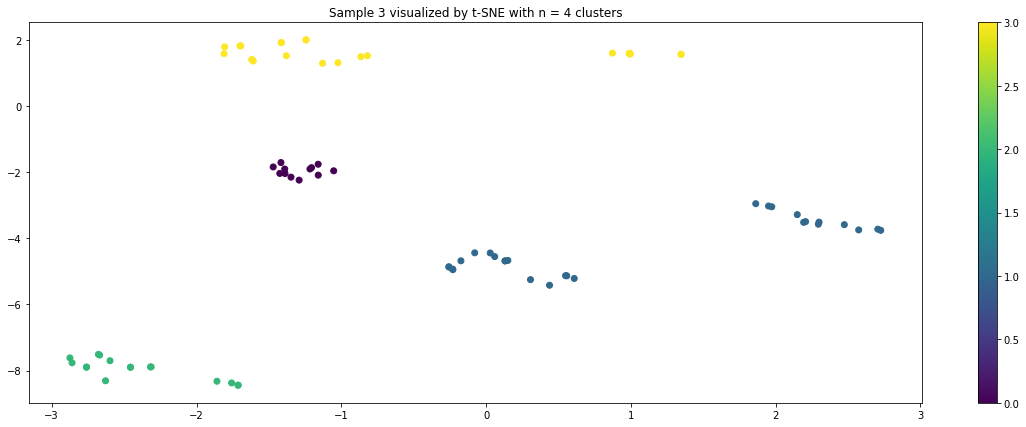

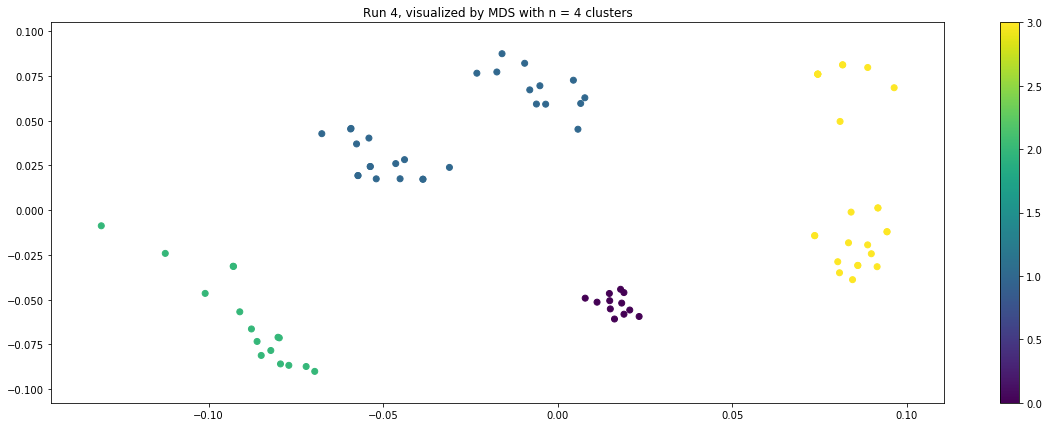

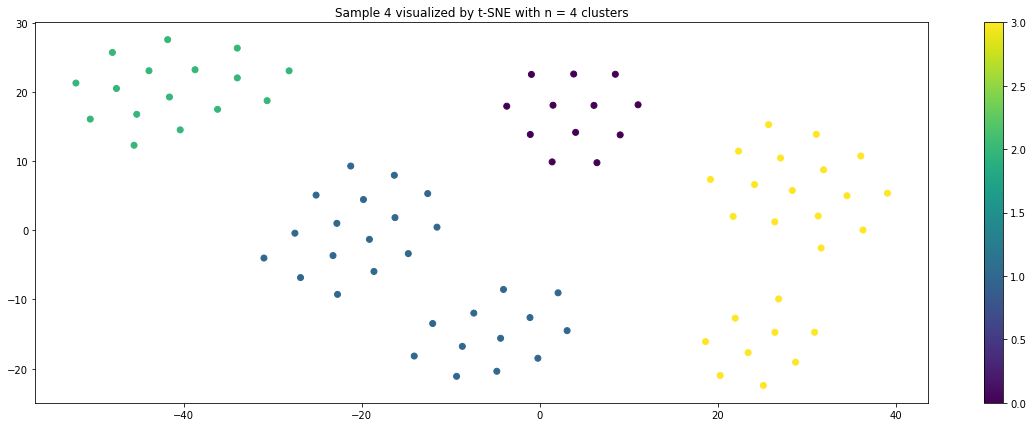

In [53]:
for testKey in mdsSOAPsthermal.keys():
    testStruct = thermalSOAPgrids[int(testKey)]
    testMDS = mdsSOAPsthermal[testKey]
    testTsne = tsneSOAPsthermal[testKey]
    plt.title("Run %s, visualized by MDS with n = 4 clusters" % testKey)
    plt.scatter(testMDS[:,0], testMDS[:,1], 
                c=kmeans.predict(testStruct), cmap='viridis')

    cb = plt.colorbar()
    plt.show()
    plt.title("Sample %s visualized by t-SNE with n = 4 clusters" % testKey)
    plt.scatter(testTsne[:,0], testTsne[:,1], 
                c=kmeans.predict(testStruct), cmap='viridis')

    cb = plt.colorbar()
    plt.show()

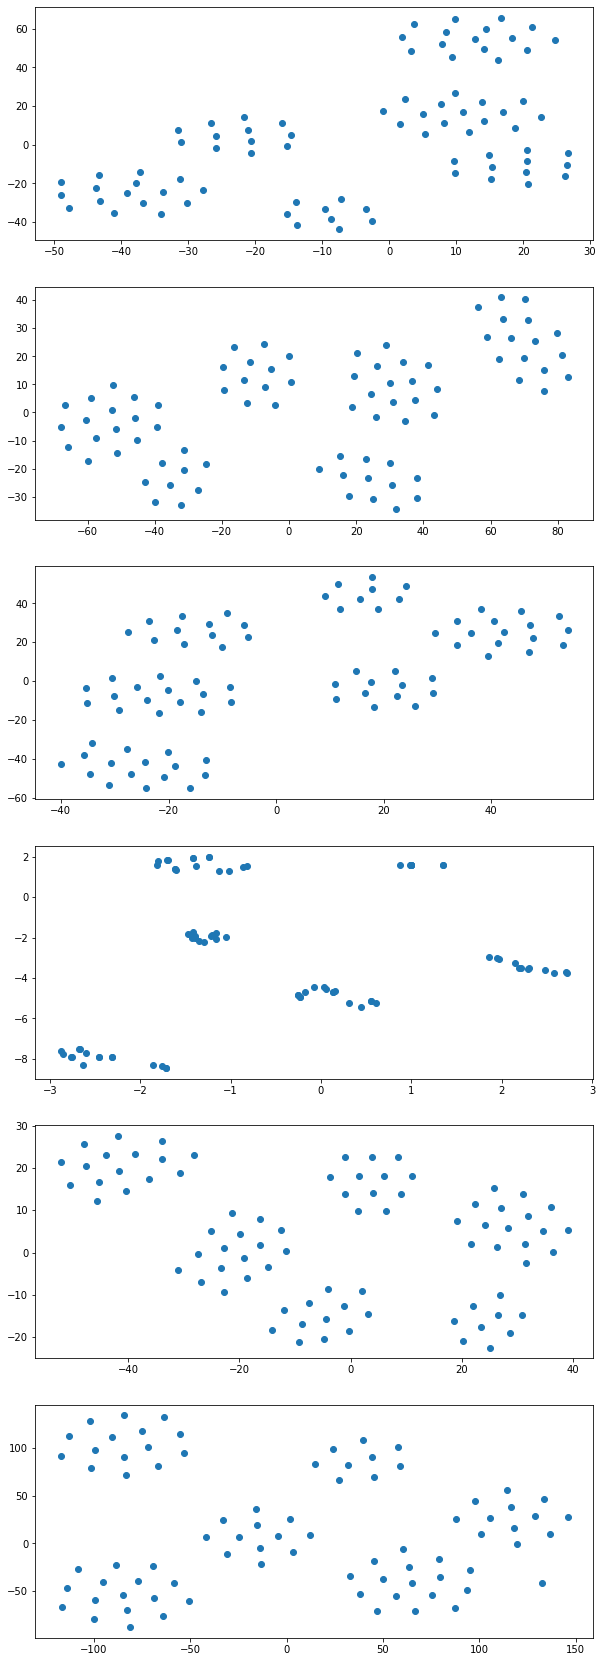

In [52]:
f, ax = plt.subplots(6, 1, figsize = (10, 30))
for label, rep in tsneSOAPsthermal.items():
    ax[label].scatter(rep[:, 0], rep[:, 1], label = label);

#     plt.legend();
#     ax[label].set_title(label)

ax[5].scatter(tsneSOAPs0K[:, 0], tsneSOAPs0K[:, 1], label = '0K');

# mpld3.display()
    

# t-SNE comparison of thermal and bombarded surface?

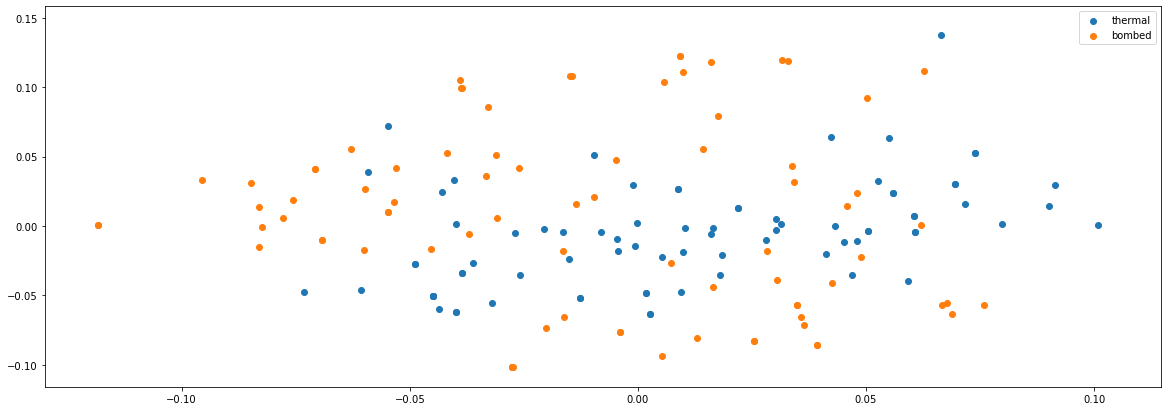

In [220]:
tempThermal = thermalSOAPgrids[0]
tempBomb = geomSOAPgrids['0-0']
# print(tempThermal.shape, tempBomb.shape)
tempCompare = np.vstack((tempThermal, tempBomb))
# print(tempCompare.shape)
labels = [0] * len(tempThermal) + [1] * len(tempBomb)

comparetSNE = transf_mds.fit_transform(tempCompare.astype(np.float64))
plt.scatter(comparetSNE[:81,0], comparetSNE[:81, 1], label = "thermal")
plt.scatter(comparetSNE[81:,0], comparetSNE[81:, 1], label = 'bombed')
plt.legend();

In [147]:
plt.figure(figsize = (10, 10))
for label, rep in tsneSOAPsbombed.items():
    plt.scatter(rep[:, 0], rep[:, 1], label = label);

plt.scatter(tsneSOAPs0K[:, 0], tsneSOAPs0K[:, 1], label = '0K');
plt.legend();
mpld3.display()

# KRR

Read in training data for adsorption

In [148]:
train_dir = "../adsorb_train_set_thermal"
name = 'output'
# name = 'geom'
raw_train_data = {name: gen.read_gen("%s/%s" % (train_dir, name)) 
                  for name in ["%s%d.gen" % (name, i) for i in np.arange(1,82)]} 
view([raw_train_data["%s%d.gen" % (name,key)] for key in np.arange(1, 82)])

Create surfaces with He according to C positions in adsorption training set

In [132]:
train_data = {}
for key in raw_train_data.keys():
    temp = raw_train_data[key].copy()
    tempbonds = Analysis(temp).all_bonds[0]
    mefbonds = []
    for i in temp:
        if i.symbol == 'C': 
            i.symbol = 'He'
            mefbonds = tempbonds[i.index]
    del temp[[i.index for i in temp if i.index in mefbonds]]
    train_data[key] = temp

In [147]:
view([train_data["%s%d.gen" % (name, key)] for key in np.arange(1, 82)])

Apply SOAP:

In [194]:
from sklearn.preprocessing import StandardScaler, scale

# StandardScaler()
desc = SOAP(species=[1, 2, 7, 14, 18], 
             rcut=5.0, 
             nmax=10, 
             lmax=9, 
             sigma=0.1, 
             periodic=True, 
             crossover=True, 
             sparse=False)
adsorption_soaps = {}
for key, struct in train_data.items():
    tempsoap = preprocessing.normalize(desc.create(struct, positions=[290]))
#     tempsoap = preprocessing.scale(desc.create(struct, positions=[290]))
    # SOAP representation of He in each struct, hardcoded at index 290!!!!!!!
    
    adsorption_soaps[key] = tempsoap[0]

Calculate adsorption energies, concatenate with representations

In [195]:
data = pd.read_csv(train_dir + "/energies", header=None)
data = data.set_index(np.arange(1, 82))
data.columns = ['energy']
# data = data + 13426.2460 + 195.5088 #xtl surf, SCC
data = data + 13426.2460 + 195.5088 #thermal surf, SCC
# data = data - -13313.3257 + 196.0817 #bombed surf, no SCC
data

# $(n \times d)$ matrix of datapoints x SOAP features

reprdata = [adsorption_soaps["%s%i.gen" % (name,i)] for i in data.index]
reprdata = pd.DataFrame(np.array([i for i in reprdata]))
reprdata.index = data.index

# Join energy and representations data for easier train/test split processing

data = data.join(reprdata)

In [196]:
data['energy']

1    -0.2629
2    -0.2629
3    -0.3591
4    -0.3589
5    -0.2629
       ...  
77   -0.2629
78   -0.2629
79   -0.3590
80   -0.3590
81   -0.2629
Name: energy, Length: 81, dtype: float64

Split into train and test sets

In [197]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:, data.columns != "energy"], data['energy'], random_state = 429)

In [217]:
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha = 1e-5, kernel = 'linear')  # gamma automatically set by sklearn.metrics.pairwise.rbf_kernel

In [218]:
#trainin! 
krr.fit((np.array(X_train)), (np.array(y_train)))

KernelRidge(alpha=1e-05, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None)

In [219]:
train_err = y_train - krr.predict(X_train)

In [220]:
test_err = krr.predict(X_test)

In [221]:
y_test

9    -0.2629
31   -0.3591
28   -0.2708
45   -0.2629
62   -0.2955
66   -0.3492
26   -0.2954
56   -0.3479
16   -0.2357
54   -0.3586
13   -0.2715
69   -0.4108
10   -0.3589
75   -0.3590
46   -0.4108
74   -0.2628
55   -0.2710
71   -0.3590
4    -0.3589
11   -0.3591
61   -0.3591
Name: energy, dtype: float64

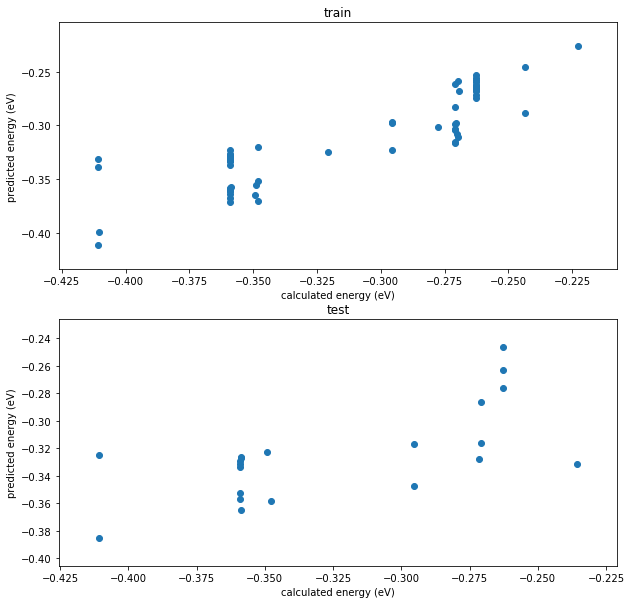

In [222]:
plt.subplots(2, 1, figsize = (10, 10))

plt.subplot(211)
plt.title('train')
plt.ylabel("predicted energy (eV)")
plt.xlabel("calculated energy (eV)")
plt.scatter(y_train, krr.predict(X_train))
plt.subplot(212)
plt.title("test")
plt.ylabel("predicted energy (eV)")
plt.xlabel("calculated energy (eV)")
plt.scatter(y_test, krr.predict(X_test))

In [204]:
krr.predict(np.repeat(np.array(X_train), 200, axis = 0))

array([-0.2629, -0.2629, -0.2629, ..., -0.2702, -0.2702, -0.2702])

In [114]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, krr.predict(X_test)), mean_absolute_error(y_train, krr.predict(X_train))

(0.04877033242469181, 0.051532943632915336)

Outliers

In [41]:
view(gen.read_gen("../input.gen"))

In [33]:
view([gen.read_gen("../adsorb_train_set_bombed//geom%d.gen" % i) for i in [61, 51, 50, 41]])